In [1]:
import numpy as np
import lbg_forecast.dust_priors as dpr
import lbg_forecast.sfh as sfh
import lbg_forecast.population_model as pop
import matplotlib.pyplot as plt

In [2]:
dust_prior = dpr.DustPrior(10000)

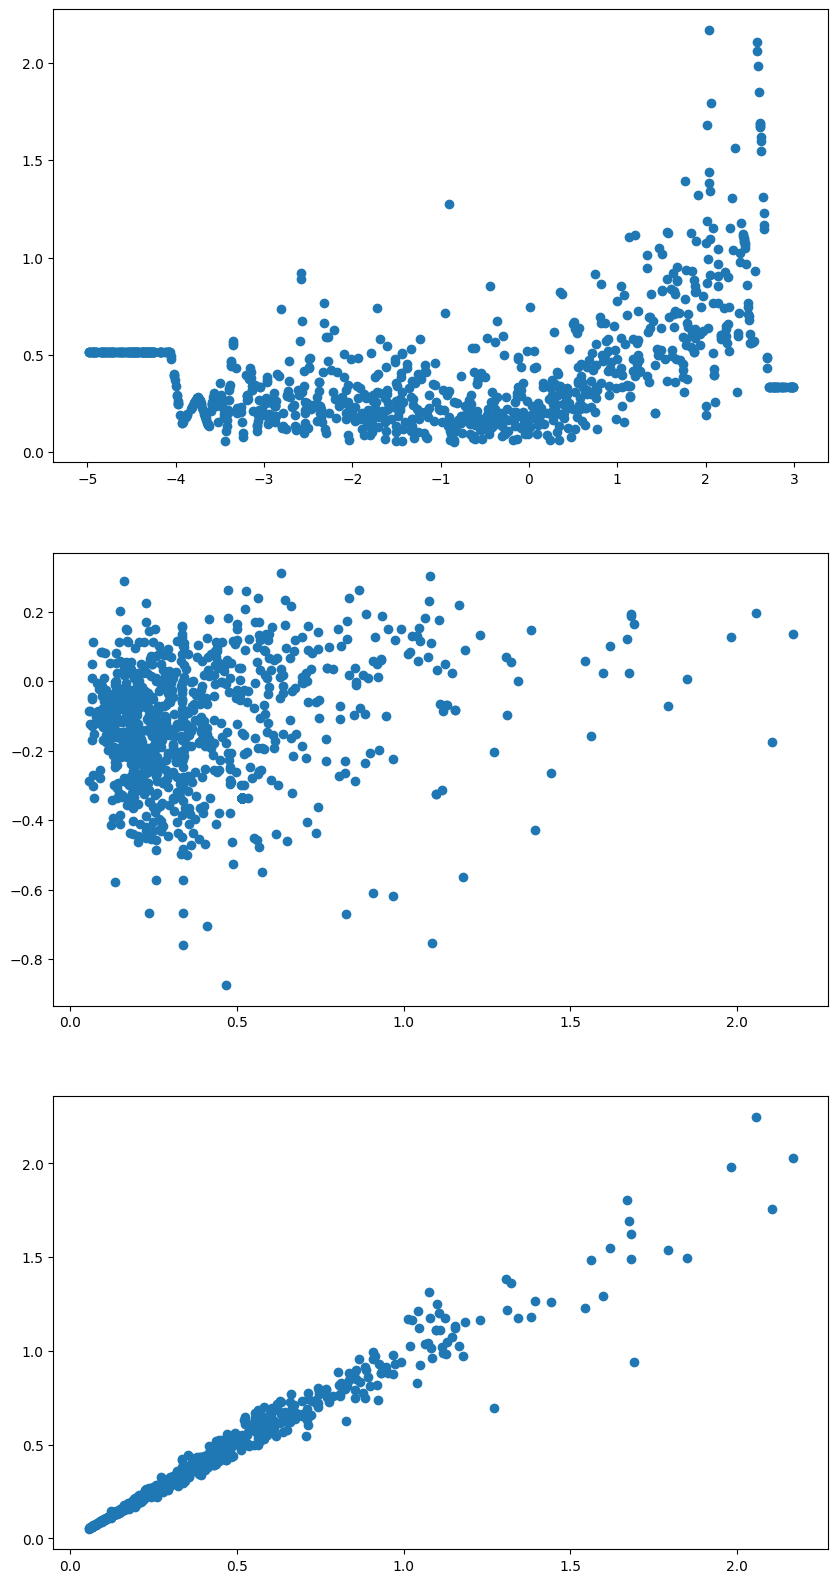

In [5]:
sfrs = np.random.uniform(-5, 3, 1000)
dust2, dust_index, dust1 = dust_prior.draw_dust_parameters(sfrs)

f, ax = plt.subplots(3, 1, figsize=(10, 20))

ax1 = ax[0]
ax2 = ax[1]
ax3 = ax[2]

ax1.scatter(sfrs, dust2)
ax2.scatter(dust2, dust_index)
ax3.scatter(dust2, dust1)